/tmp/ipykernel_1669860/1873234442.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df1.groupby(['cellAnnotation', 'Label']).size().unstack(fill_value=0)
/tmp/ipykernel_1669860/1873234442.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df2.groupby(['cellAnnotation', 'Label']).size().unstack(fill_value=0)


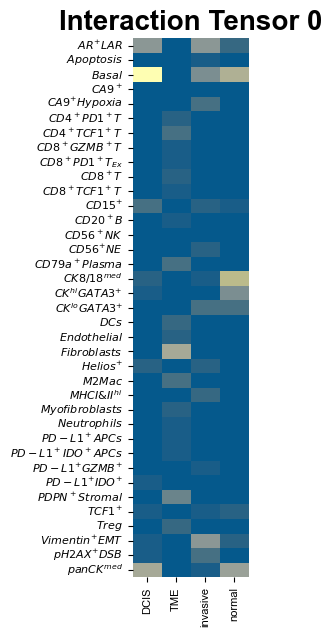

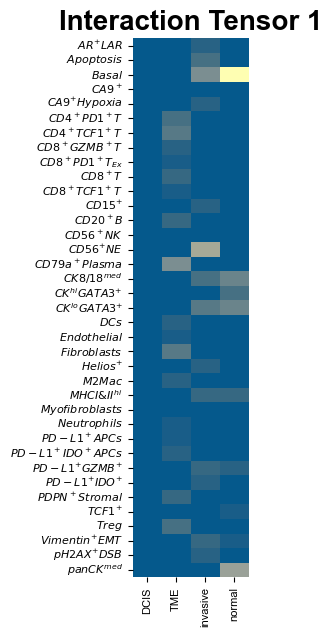

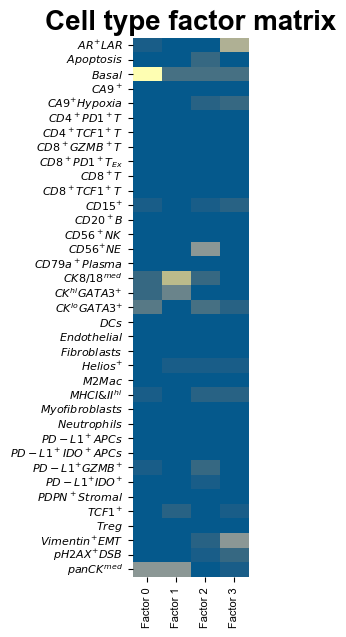

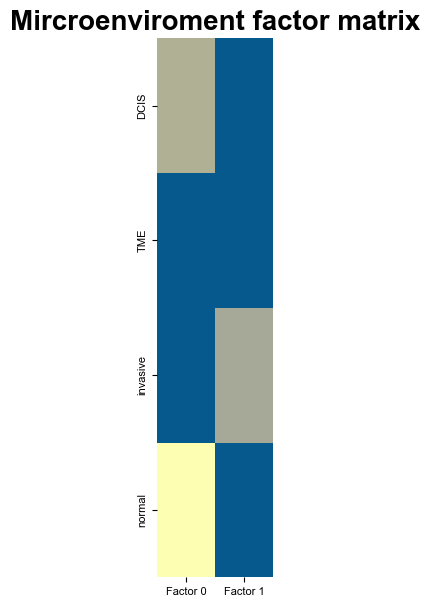

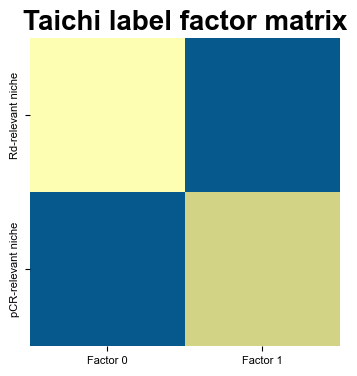

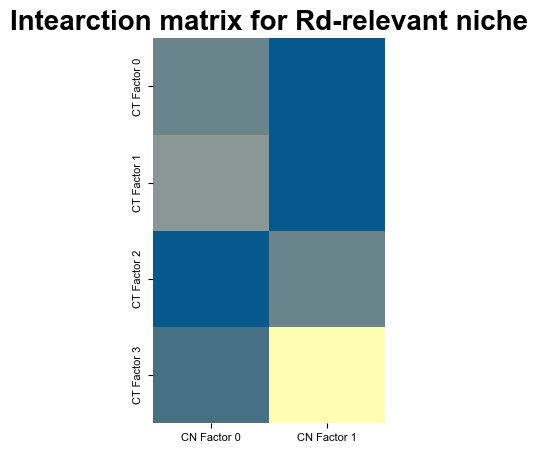

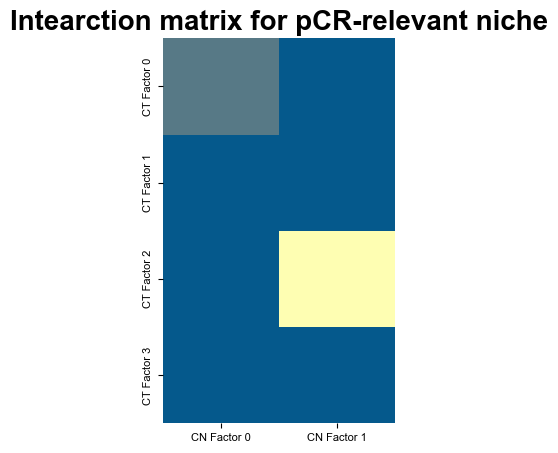

In [2]:
import seaborn as sns
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_tucker, non_negative_tucker_hals
import time
from tensorly.metrics.regression import RMSE
import matplotlib.pyplot as plt
import seaborn as sns
import  palettable
from palettable.scientific.diverging  import Vik_20, Berlin_20
from palettable.scientific.sequential import Nuuk_20
from matplotlib.colors import  ListedColormap
import scanpy as sc

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20  # Adjust title size
plt.rcParams['axes.labelsize'] = 15

train_adata = sc.read_h5ad('/home/cuiyan/mms/tnbc_res.h5ad')

def tensor_decompose(train_adata):

    cmap = ListedColormap(Nuuk_20.mpl_colors)
    
    df1 = train_adata[train_adata.obs['new_labels'] == 0].obs 

    grouped = df1.groupby(['cellAnnotation', 'Label']).size().unstack(fill_value=0)

    # Calculate percentages
    percentages1 = grouped.div(grouped.sum(axis=1), axis=0) * 100

    df2 = train_adata[train_adata.obs['new_labels'] == 1].obs 

    grouped = df2.groupby(['cellAnnotation', 'Label']).size().unstack(fill_value=0)

    # Calculate percentages
    percentages2 = grouped.div(grouped.sum(axis=1), axis=0) * 100


    values = np.stack([percentages1.values.T,
    np.concatenate([np.zeros(percentages2.shape[1]).reshape(-1,1), percentages2.values.T], axis=1)], axis=0)


    tensor = tl.tensor(values, dtype='float')

    row_labels = [rf'${c}$' for c in list(percentages2.columns)]
    col_labels = [rf'{c}' for c in list(percentages1.index.values)]

    
    plt.figure(figsize=(1.5, 7))
    ax = sns.heatmap(values[0], annot=False, fmt=".2f", xticklabels=col_labels, yticklabels=row_labels, cmap=cmap, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, fontweight=500)  # Adjust x label font size here
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8, fontweight=500)  # Adjust y label font size her
    plt.title('Interaction Tensor 0')

    plt.figure(figsize=(1.5, 7))
    ax = sns.heatmap(values[1], annot=False, fmt=".2f", xticklabels=col_labels, yticklabels=row_labels, cmap=cmap, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, fontweight=500)  # Adjust x label font size here
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8, fontweight=500) 
    plt.title('Interaction Tensor 1')
    
    core, tucker_factors = non_negative_tucker(tensor, rank=[2, 4, 2], tol=1e-12, n_iter_max=100)

    plt.figure(figsize=(1.5, 7))

    row_labels = [ rf'${c}$' for c in list(percentages2.columns)]
    col_labels = ['Factor {}'.format(i) for i in range(4)]

    ax = sns.heatmap(tucker_factors[1], annot=False, fmt=".2f", xticklabels=col_labels, yticklabels=row_labels, cmap=cmap, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, fontweight=500)  # Adjust x label font size here
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8, fontweight=500) 
    plt.title('Cell type factor matrix')
    plt.figure(figsize=(1.5, 7))

    row_labels = list(percentages1.index.values)
    col_labels = ['Factor {}'.format(i) for i in range(2)]

    ax = sns.heatmap(tucker_factors[2], annot=False, fmt=".2f", xticklabels=col_labels, yticklabels=row_labels, cmap=cmap, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, fontweight=500)  # Adjust x label font size here
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8, fontweight=500) 
    plt.title('Mircroenviroment factor matrix')


    plt.figure(figsize=(4, 4))

    row_labels = ['Rd-relevant niche', 'pCR-relevant niche']
    col_labels = ['Factor {}'.format(i) for i in range(2)]

    ax = sns.heatmap(tucker_factors[0], annot=False, fmt=".2f", xticklabels=col_labels, yticklabels=row_labels, cmap=cmap, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, fontweight=500)  # Adjust x label font size here
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8, fontweight=500) 
    plt.title('Taichi label factor matrix')


    plt.figure(figsize=(3, 5))

    row_labels = ['CT Factor {}'.format(i) for i in range(4)]
    col_labels = ['CN Factor {}'.format(i) for i in range(2)]

    ax = sns.heatmap(core[0], annot=False, fmt=".2f", xticklabels=col_labels, yticklabels=row_labels, cmap=cmap, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, fontweight=500)  # Adjust x label font size here
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8, fontweight=500) 
    plt.title('Intearction matrix for Rd-relevant niche')

    plt.figure(figsize=(3, 5))

    row_labels = ['CT Factor {}'.format(i) for i in range(4)]
    col_labels = ['CN Factor {}'.format(i) for i in range(2)]

    ax = sns.heatmap(core[1], annot=False, fmt=".2f", xticklabels=col_labels, yticklabels=row_labels, cmap=cmap, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, fontweight=500)  # Adjust x label font size here
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8, fontweight=500) 
    plt.title('Intearction matrix for pCR-relevant niche')
    return #core, tucker_factors

tensor_decompose(train_adata)